## <h1><center>Momentum</center></h1>
<h2><center>Still Relevant Today?</center></h2>

<h4>
QuantCon Singapore 2016<br>
Anthony Ng<br>
anthony@gmail.com<br>
11 Nov 2016<br>
</h4>


<h1>Disclaimer</h1>

* None of the contents constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory services<br>
* Past performance is no indicator of future performance<br>
* Provided for informational purposes only<br> 
* All investments involve risk, including loss of principal<br>


<h1><center>Momentum</center></h1>
* **[Cross-Sectional Momentum. Jegadeesh and Titman (1993)](http://www.bauer.uh.edu/rsusmel/phd/jegadeesh-titman93.pdf)**<br>
  Rank the cross-section of stocks each month based on their return over the past 6 mths
Form decile portfolios each month



* **[Time Series Momentum. Moskowitz, Ooi and Pedersen (2012)](http://quantpedia.com/screener/Details/118)**<br>
  Takes long or short position on an asset by only looking back at its own performance during the formation period, and not based on its relative rank across a cross-section


<h1>Approach and Data</h1>

In this notebook, we aim to replicate the **Time Series Momentum(TSMOM) Moskowitz, Ooi and Pedersen (MOP)** paper. We examined the TSMOM performance by using the same futures contracts and time period (1984 - 2009). After which, we extended the testing period to include Oct 2016. As a form of benchmark, we also examined the buy-and-hold with and without volatility scaling strategy as advocated by **Kim, Tse and Wald** in their **Time Series Momentum and Volatility Scaling** (2016) paper. Data were sourced from Bloomberg.

* 9 developed countries index futures
* 24 commodities futures
* 13 bond futures
* 9 currencies futures
* Jul 1959 - Oct 2016

# Volatility Scaling

In MOP paper, under section 2.4, they discussed using ex ante volatility estimate to scale capital allocation to different futures contract based on each future contracts volatility. The basic idea is very similar to risk bedgeting or risk parity. The following is their explanation:

  *...Since volatility varies dramatically across our assets, we scale the returns by their volatilities in order to make meaningful comparisons across assets. We estimate each instrument's ex ante volatility $\sigma_t$ at each point in time using an extremely simple model: the exponential weighted lagged squared daily returns (i.e., similar to a simple univatiate GARCH model). Specifically, the ex ante annualized variance $\sigma^2_t$ for each instrument is calculated as follows*:
$$\sigma^2_t=261\sum^\infty_{i=0}(1-\delta)\delta^i(r_{t-1-i}-\bar{r}_t)^2$$

  *where the scalar 261 scales the variance to be annual, the weights $(1-\delta)\delta^i$ add up to one, and $\bar{r}_t$ is the exponentially weighted average return computed similarly. The parameter $\delta$ is chosen so that the center of mass of the weights is $\sum^{\infty}_{i=0}(1-\delta)\delta^ii=\delta/(1-\delta)=60$ days. The volatility model is the same for all assets at all times... *

In [1]:
import numpy as np
import pandas as pd
import datetime
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pytz

In [2]:
tolerance = 0.
look_back = 12

# Vol scaling
vol_flag = 1                  # Set flag to 1 for vol targeting
if vol_flag == 1:
    target_vol = 0.4
else:
    target_vol = 'no target vol'

# 1. Trading Strategy - TSMOM with Volatility Scaling (1984 - 2009)
As per MOP paper covering 1984 - 2009

# 1a. Individual Futures Performance

In [3]:
res = local_csv("futures.csv")
# res = local_csv("futures_incl_2016.csv") # Uncomment this line to include 2016
res['Date'] = pd.to_datetime(res['Date'], format='%Y-%m-%d')
res.set_index('Date', inplace=True)

In [4]:
std_index = res.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', \
                                    'Skew', 'Kurt', 'Sharpe Ratio'])

In [5]:
for oo in res.columns:
    returns = res[oo]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [oo, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    ret_m_index.ix[0][oo] = 1

    mth_index = pd.concat([mth_index, ret_m_index[oo]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = oo + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[oo].pct_change().mean()*252
    tmp_std = ret_index[oo].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[oo].pct_change().skew()
    tmp_kurt = ret_index[oo].pct_change().kurt()
    sr = tmp_mean / tmp_std

    dict = {'Asset': oo,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[oo] = pd.Series(dict)    

In [6]:
summary_stats = summary_stats.transpose()
futures_list = local_csv("futures_list.csv")
all = summary_stats.reset_index().merge(futures_list)
all.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del all['Asset'], all['index']

### Individual Futures Contracts Performance
These are annualized performance.

In [7]:
all.set_index(['ASSET_CLASS', 'FUTURES']).style.set_properties(**{'text-align': 'right'})

# 1b. Trading Strategy - TSMOM with Volatility Scaling (1984 - 2009)


Perform a Time Series Momentum strategy on each price series.
* Long those with positive momentum
* Short those with negative momentum

In [8]:
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [9]:
for oo in mth_index:
    df = pd.concat([mth_index[oo], mth_index_vol[oo+"_Vol"]], axis=1)
    df['returns'] = df[oo].pct_change(look_back)
    
    df['pnl'] = 0.
    df['leverage'] = 0.
    try:
        for k, v in enumerate(df['returns']):
            if k <= look_back:
                # skip the first 12 observations
                continue
            if df['returns'].iloc[k-1] < tolerance:
                # negative returns, sell and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1)                   
                    df['leverage'].iloc[k] = 1.
            elif df['returns'].iloc[k-1] > tolerance:
                # positive returns, buy and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) 
                    df['leverage'].iloc[k] = 1.
    except: pass    
    # convert to cummulative index
    pnl = pd.concat([pnl, df['pnl']], axis=1)
    leverage = pd.concat([leverage, df['leverage']], axis=1)
    
    ret_index = (1 + df['pnl'][13:]).cumprod()
    ret_index[0] = 1
    strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1) 

In [10]:
pnl.columns = res.columns
leverage.columns = leverage.columns
strategy_cumm_rtns.columns = res.columns
df = pnl
df['port_avg'] = df.mean(skipna = 1, axis=1)
Strategy = df['port_avg'].copy()
Strategy.name = "TSMOM with Vol"
dataport_index = (1 + df['port_avg']).cumprod()

In [11]:
print "Annualized Sharpe Ratio = ", pf.empyrical.sharpe_ratio(df['port_avg'], period='monthly')
print "Annualized Mean Returns = ", pf.empyrical.annual_return(df['port_avg'], period='monthly')
print "Annualized Standard Deviations = ", pf.empyrical.annual_volatility(df['port_avg'], period='monthly')

Annualized Sharpe Ratio =  1.55942862102
Annualized Mean Returns =  0.158205253154
Annualized Standard Deviations =  0.0977748556597


In [12]:
print "Max Drawdown = ", pf.empyrical.max_drawdown(df['port_avg'])
print "Calmar ratio = ", pf.empyrical.calmar_ratio(df['port_avg'], period='monthly')

Max Drawdown =  -0.140726202907
Calmar ratio =  1.12420608164


# Other Strategies

The performance of Time Series Momentum with volatility scaling (MOP strategy) up to and including Sep 2016 (not shown) is:

* Annualized Sharpe Ratio =  1.32240147363
* Annualized Mean Returns =  0.144648073277
* Annualized Standard Deviations =  0.107003671777
* Max Drawdown =  -0.140726203354
* Calmar ratio =  1.02786879649

The performance of Time Series Momentum without volatility scaling is:

* Annualized Sharpe Ratio =  1.18250924383
* Annualized Mean Returns =  0.0593476792819
* Annualized Standard Deviations =  0.0499137056686
* Max Drawdown =  -0.125187506104
* Calmar ratio =  0.474070305648

Entire data start date: 1984-01-30
Entire data end date: 2009-12-30


Backtest Months: 14


Performance statistics,Backtest
annual_return,20.85
annual_volatility,0.45
sharpe_ratio,7.15
calmar_ratio,148.18
stability_of_timeseries,0.96
max_drawdown,-0.14
omega_ratio,3.37
sortino_ratio,15.12
skew,0.14
kurtosis,0.77


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,14.07,2003-05-29,2003-08-28,2003-12-30,153
1,13.54,2009-02-26,2009-07-30,NaT,NaN
2,9.17,2008-06-29,2008-09-29,2008-10-30,89
3,7.82,2004-03-30,2004-07-29,2004-10-28,153
4,7.33,2007-06-28,2007-08-30,2007-10-30,89




[-0.061 -0.061]


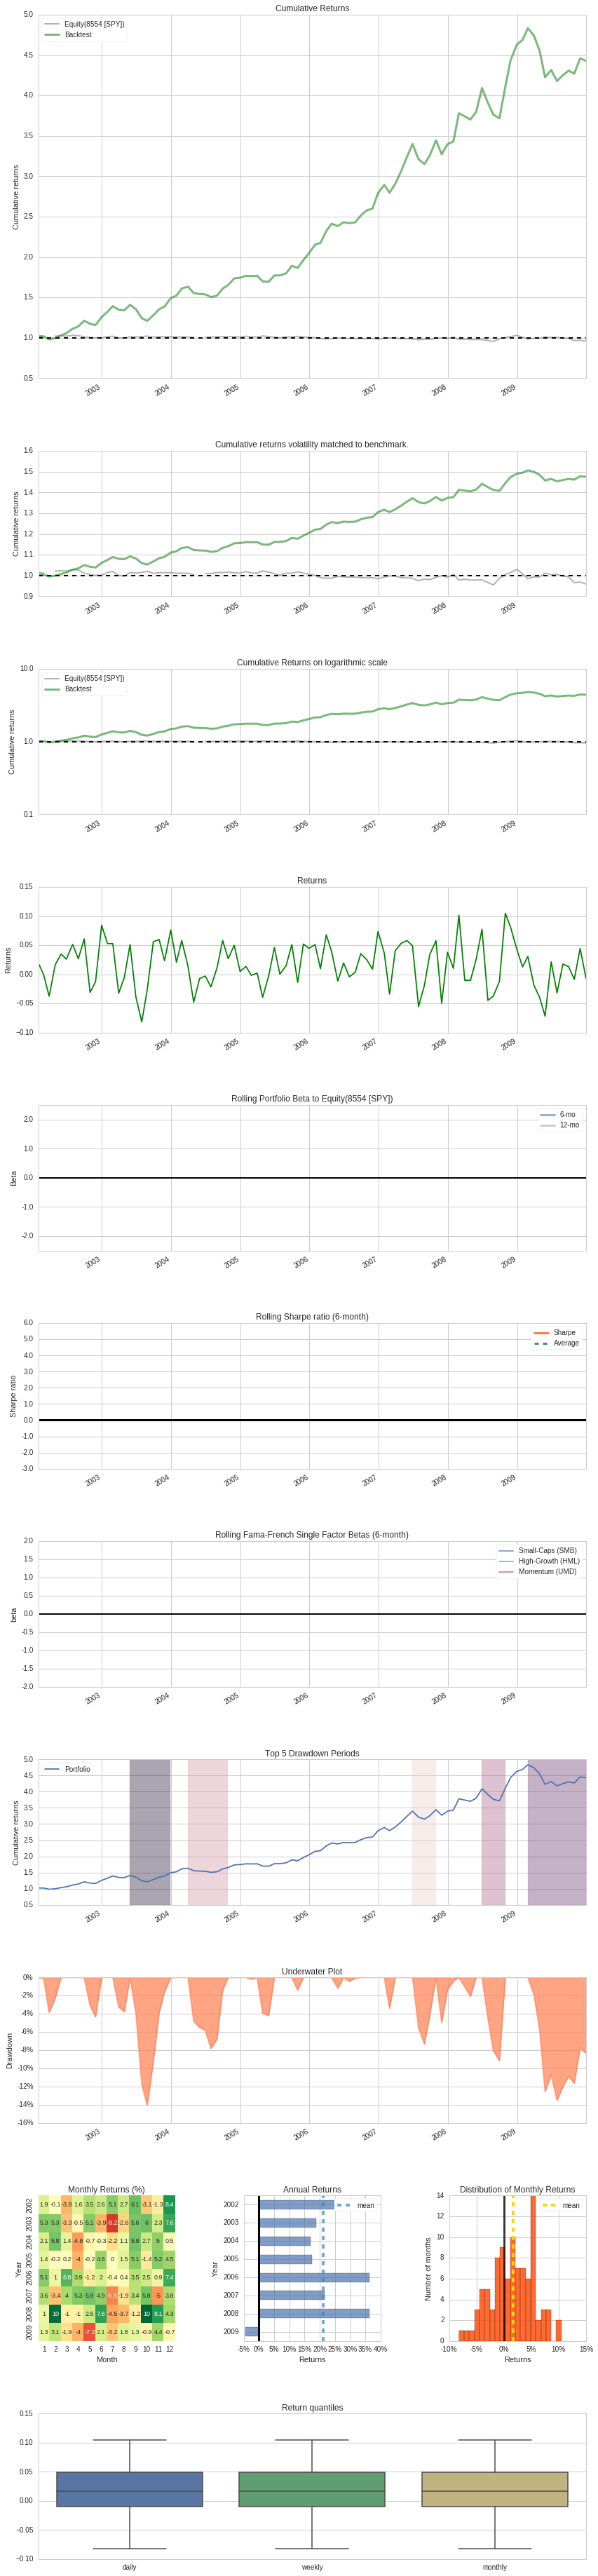

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Dotcom,2.44%,-2.87%,5.45%
Lehmann,-2.47%,-3.74%,-1.21%
9/11,9.52%,9.52%,9.52%
US Housing,5.28%,5.28%,5.28%
Aug07,-1.90%,-1.90%,-1.90%
Mar08,-1.04%,-1.04%,-1.04%
Sept08,-1.21%,-1.21%,-1.21%
2009Q1,2.17%,1.28%,3.07%
2009Q2,-4.35%,-7.21%,-1.88%
Low Volatility Bull Market,2.04%,-5.54%,7.36%


KeyError: 'Dotcom'

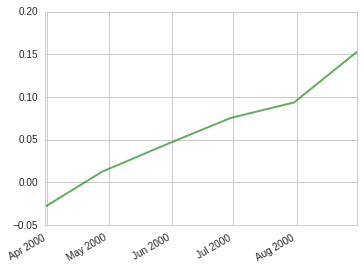

In [13]:
eastern = pytz.timezone('US/Eastern')
df['port_avg'].index = df['port_avg'].index.tz_localize(pytz.utc).tz_convert(eastern)
pf.create_full_tear_sheet(df['port_avg'])

*****

# Further Analysis

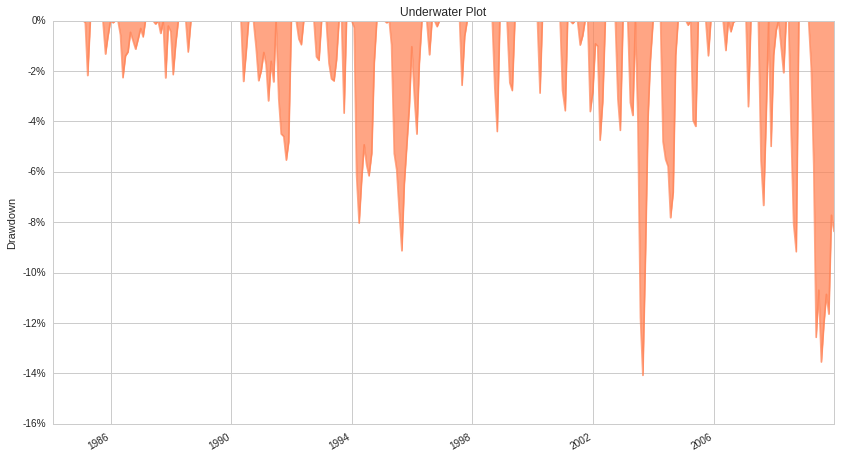

In [14]:
pf.plot_drawdown_underwater(df['port_avg']);

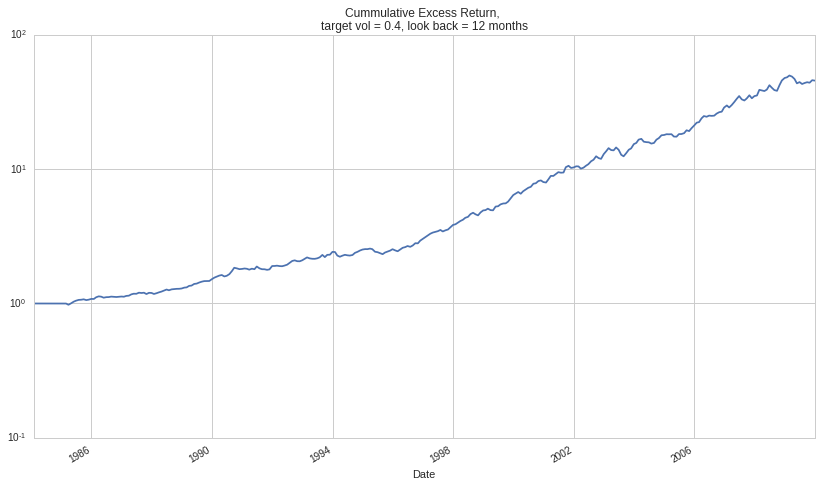

In [15]:
ax = (1 + df['port_avg']).cumprod().plot(logy=True);
ax.set_title("Cummulative Excess Return, " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months");

In [16]:
tmp = df['port_avg'].reset_index()
tmp['Date'] = pd.to_datetime(tmp['Date'], format='%Y-%m-%d')
tmp = tmp.set_index('Date')
tmp['month'] = tmp.index.month
tmp['year'] = tmp.index.year
tmp = np.round(tmp, 3)
res = tmp.pivot('year', 'month', 'port_avg')
res['total'] = np.sum(res, axis=1)

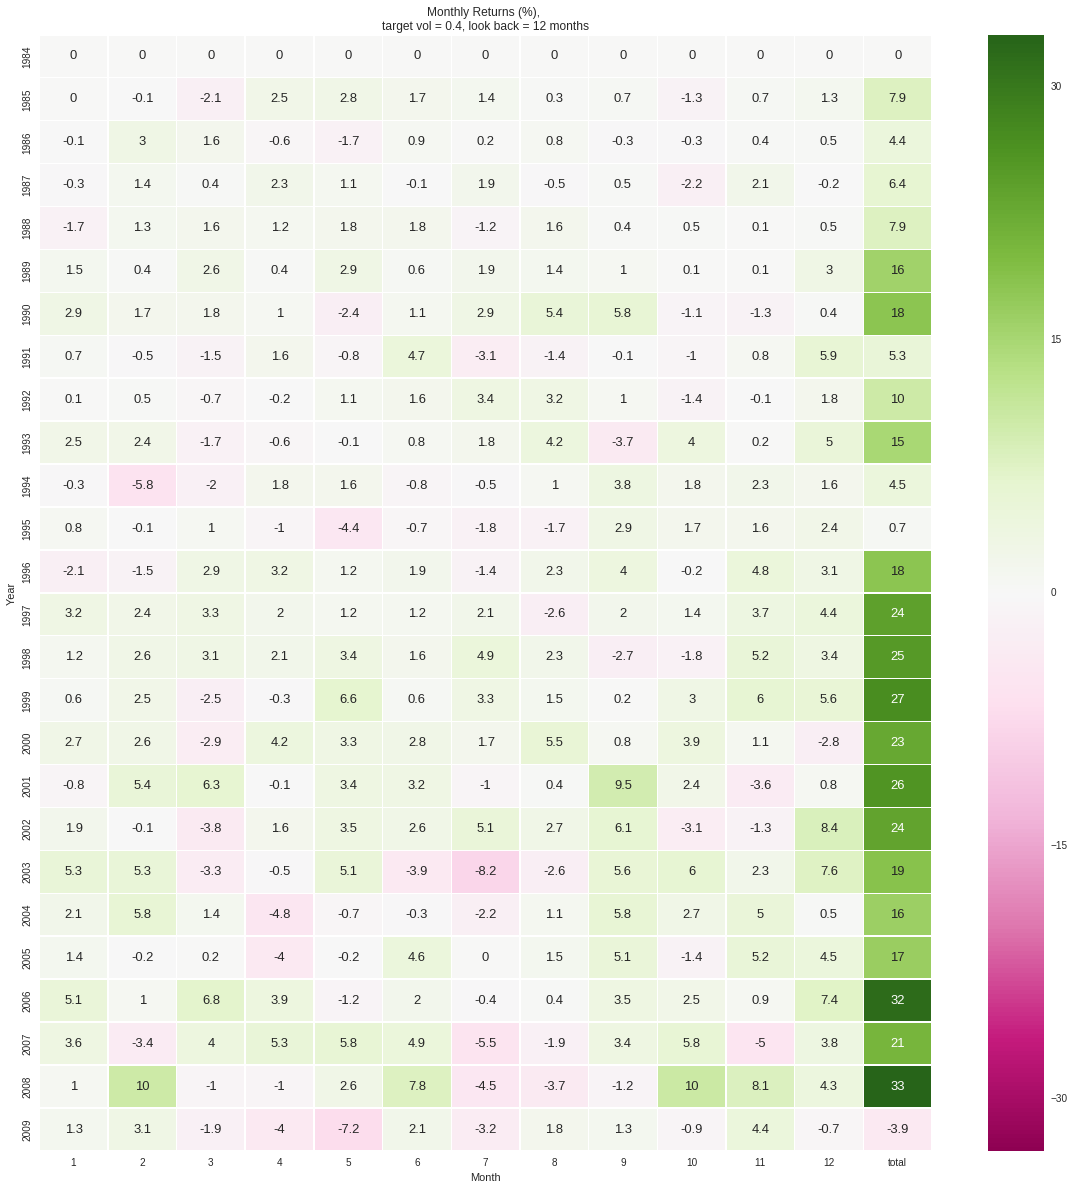

In [17]:
fig, ax = plt.subplots(figsize=(20,20));
sns.heatmap(res.fillna(0) * 100,
            annot=True,
            annot_kws={
                "size": 13},
            alpha=1.0,
            center=0.0,
            cbar=True,
            cmap=matplotlib.cm.PiYG,
            linewidths=.5,
            ax = ax); 
ax.set_ylabel('Year');
ax.set_xlabel('Month');
ax.set_title("Monthly Returns (%), " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months");
plt.show()

# 2. Buy-and-Hold Without Volatility Scaling Strategy (1984 - 2009)
Buy-and-hold with and without volatility scaling strategy as advocated by **Kim, Tse and Wald** in their **Time Series Momentum and Volatility Scaling** (2016) paper.

The performance with volatility scaling is not shown in this notebook. It can be easily accomodated by adding this two addition line:
* vol_flag = 1
* target_vol = 0.4

With volatility scaling, the result is:
* Annualized Sharpe Ratio =  -0.0882482424146
* Annualized Mean Returns =  -0.022460936792
* Annualized Standard Deviations =  0.142189626101
* Max Drawdown =  -0.793868253586
* Calmar ratio =  -0.0282930280818




In [18]:
res = local_csv("futures.csv")
res['Date'] = pd.to_datetime(res['Date'], format='%Y-%m-%d')
res.set_index('Date', inplace=True)
std_index = res.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', 'Skew', 'Kurt', 'Sharpe Ratio'])

In [19]:
for oo in res.columns:
    returns = res[oo]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [oo, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    ret_m_index.ix[0][oo] = 1

    mth_index = pd.concat([mth_index, ret_m_index[oo]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = oo + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[oo].pct_change().mean()*252
    tmp_std = ret_index[oo].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[oo].pct_change().skew()
    tmp_kurt = ret_index[oo].pct_change().kurt()
    sr = tmp_mean / tmp_std

    dict = {'Asset': oo,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[oo] = pd.Series(dict)    

In [20]:
summary_stats = summary_stats.transpose()
futures_list = local_csv("futures_list.csv")
all = summary_stats.reset_index().merge(futures_list)
all.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del all['Asset'], all['index']
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [21]:
vol_flag = 0  # change to flag to 1 to volatility scale the strategy
#target_vol = 0.4

In [22]:
for oo in mth_index:
    df = pd.concat([mth_index[oo], mth_index_vol[oo+"_Vol"]], axis=1)
    df['returns'] = df[oo].pct_change(look_back)
    
    df['pnl'] = 0.
    df['leverage'] = 0.
    try:
        for k, v in enumerate(df['returns']):
            if k <= look_back:
                # skip the first 12 observations
                continue
            if vol_flag == 1:
                df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) * \
                                    target_vol / df[oo+'_Vol'].iloc[k - 1]
                df['leverage'].iloc[k] = target_vol / df[oo+'_Vol'].iloc[k - 1]
            else:
                df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1)                   
                df['leverage'].iloc[k] = 1.
    except:
        pass  
    # convert to cummulative index
    pnl = pd.concat([pnl, df['pnl']], axis=1)
    leverage = pd.concat([leverage, df['leverage']], axis=1)
    
    ret_index = (1 + df['pnl'][13:]).cumprod()
    ret_index[0] = 1
    strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1) 

In [23]:
pnl.columns = res.columns
leverage.columns = leverage.columns
strategy_cumm_rtns.columns = res.columns
df = pnl
df['port_avg'] = df.mean(skipna = 1, axis=1)

temp = df['port_avg'].copy()
temp.name = "Buy_Hold No Vol"
temp.index = temp.index.tz_localize(pytz.utc).tz_convert(eastern)
Strategy.index = Strategy.index.tz_localize(pytz.utc).tz_convert(eastern)
Strategy = pd.concat([Strategy, temp], axis=1)

dataport_index = (1 + df['port_avg']).cumprod()

In [24]:
print "Annualized Sharpe Ratio = ", pf.empyrical.sharpe_ratio(df['port_avg'], period='monthly')
print "Annualized Mean Returns = ", pf.empyrical.annual_return(df['port_avg'], period='monthly')
print "Annualized Standard Deviations = ", pf.empyrical.annual_volatility(df['port_avg'], period='monthly')

Annualized Sharpe Ratio =  0.196406771186
Annualized Mean Returns =  0.0115582210137
Annualized Standard Deviations =  0.0718082068149


In [25]:
print "Max Drawdown = ", pf.empyrical.max_drawdown(df['port_avg'])
print "Calmar ratio = ", pf.empyrical.calmar_ratio(df['port_avg'], period='monthly')

Max Drawdown =  -0.320576124342
Calmar ratio =  0.0360545285069


Entire data start date: 1984-01-30
Entire data end date: 2009-12-30


Backtest Months: 14


Performance statistics,Backtest
annual_return,0.27
annual_volatility,0.33
sharpe_ratio,0.90
calmar_ratio,0.85
stability_of_timeseries,0.40
max_drawdown,-0.32
omega_ratio,1.17
sortino_ratio,1.25
skew,-0.96
kurtosis,6.51


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,32.06,2008-06-29,2009-02-26,NaT,NaN
1,3.94,2006-04-27,2006-09-28,2006-11-29,154
2,3.93,2003-02-27,2003-03-30,2003-05-29,66
3,3.83,2008-02-28,2008-03-30,2008-06-29,87
4,2.63,2006-11-29,2007-01-30,2007-04-29,108




[-0.049 -0.049]


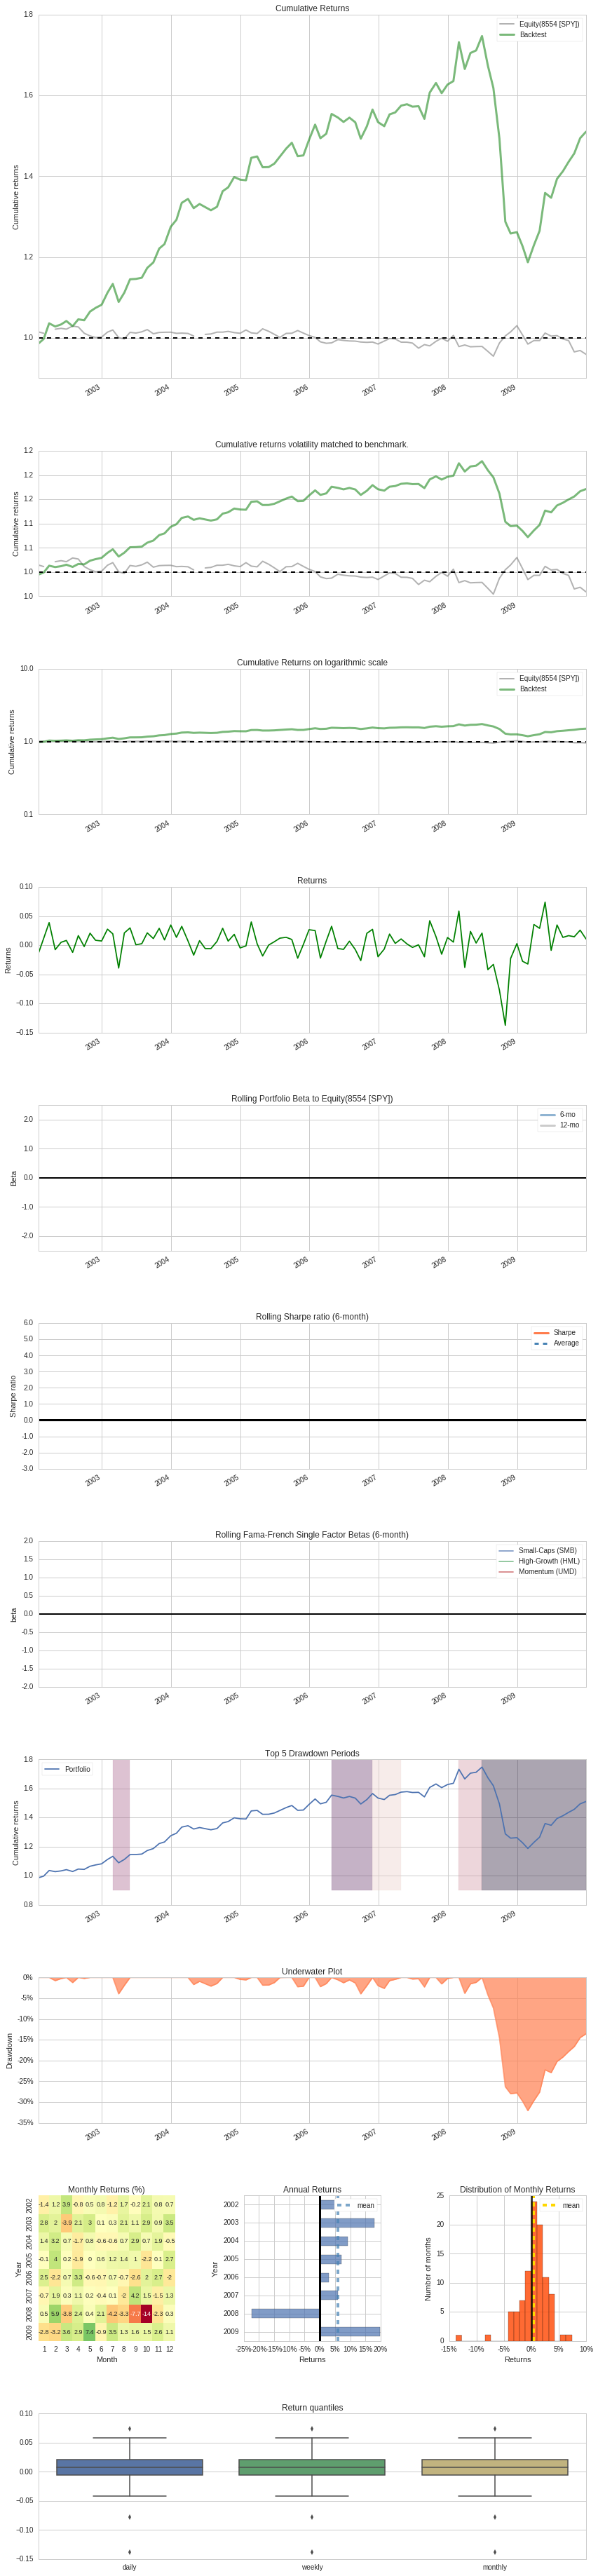

Stress Events,mean,min,max
Dotcom,0.47%,-1.82%,2.90%
Lehmann,-5.52%,-7.75%,-3.30%
9/11,-5.01%,-5.01%,-5.01%
US Housing,2.76%,2.76%,2.76%
Aug07,-1.99%,-1.99%,-1.99%
Mar08,-3.83%,-3.83%,-3.83%
Sept08,-7.75%,-7.75%,-7.75%
2009Q1,-3.00%,-3.23%,-2.76%
2009Q2,4.62%,2.90%,7.41%
Low Volatility Bull Market,0.41%,-2.65%,4.00%


KeyError: 'Dotcom'

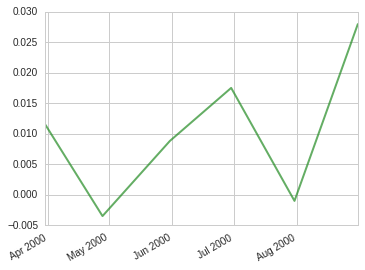

In [26]:
eastern = pytz.timezone('US/Eastern')
df['port_avg'].index = df['port_avg'].index.tz_localize(pytz.utc).tz_convert(eastern)
pf.create_full_tear_sheet(df['port_avg'])

# Factor Analysis

In [27]:
import statsmodels.api as sm

## TSMOM Volatility Scaled (1984 - 2009) [Same as MOP paper]

In [28]:
TSMOM = Strategy.reset_index()[["Date", "TSMOM with Vol"]]
TSMOM = TSMOM.set_index("Date").tz_convert(None)
TSMOM = TSMOM.reset_index()

In [29]:
df = local_csv("factors.csv")
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
data = df.merge(TSMOM)

In [30]:
data = data[['Date', 'SMB', 'HML', 'Mom', 'bond_index', 'equity_index', \
             'commodity_index', 'TSMOM with Vol']].copy()
data.columns = ['Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'PORTFOLIO']
data = data.dropna()
data = data.set_index("Date")
data = data.reset_index()

In [31]:
X = data[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X = sm.add_constant(X)
model = sm.OLS(data['PORTFOLIO'].astype(float), X).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:              PORTFOLIO   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.140
Date:                Tue, 22 Nov 2016   Prob (F-statistic):             0.0487
Time:                        10:50:11   Log-Likelihood:                 677.30
No. Observations:                 312   AIC:                            -1341.
Df Residuals:                     305   BIC:                            -1314.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0120      0.002      6.797      0.0

## Buy-and-Hold without Vol (1984 - 2009)

In [32]:
BH_no_V = Strategy.reset_index()[["Date", "Buy_Hold No Vol"]]
BH_no_V = BH_no_V.set_index("Date").tz_convert(None)
BH_no_V = BH_no_V.reset_index()

In [33]:
data = df.merge(BH_no_V)
data = data[['Date', 'SMB', 'HML', 'Mom', 'bond_index', 'equity_index', \
             'commodity_index', 'Buy_Hold No Vol']].copy()
data.columns = ['Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'PORTFOLIO']
data = data.dropna()
data = data.set_index("Date")
data = data.reset_index()

In [34]:
X = data[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X = sm.add_constant(X)
model = sm.OLS(data['PORTFOLIO'].astype(float), X).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:              PORTFOLIO   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     103.1
Date:                Tue, 22 Nov 2016   Prob (F-statistic):           2.14e-70
Time:                        10:50:11   Log-Likelihood:                 940.05
No. Observations:                 312   AIC:                            -1866.
Df Residuals:                     305   BIC:                            -1840.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.763      0.4

# Summary
Buy and Hold without volatility scaling strategy showed that it is postively correlated to bond, equity and commodity. The p-value also showed that these are significant.

*****

# Comparing TSMOM with S&P 500

In [35]:
SPX = df[["Date", "spx"]].copy()
SPX["Date"] = pd.to_datetime(SPX['Date'], format='%Y-%m-%d')

In [36]:
TSMOM = Strategy.reset_index()[["Date", "TSMOM with Vol"]].dropna()
TSMOM = TSMOM.set_index("Date").tz_convert(None)
TSMOM = TSMOM.reset_index()
#TSMOM["Date"] = pd.to_datetime(TSMOM['Date'], format='%Y-%m-%d')

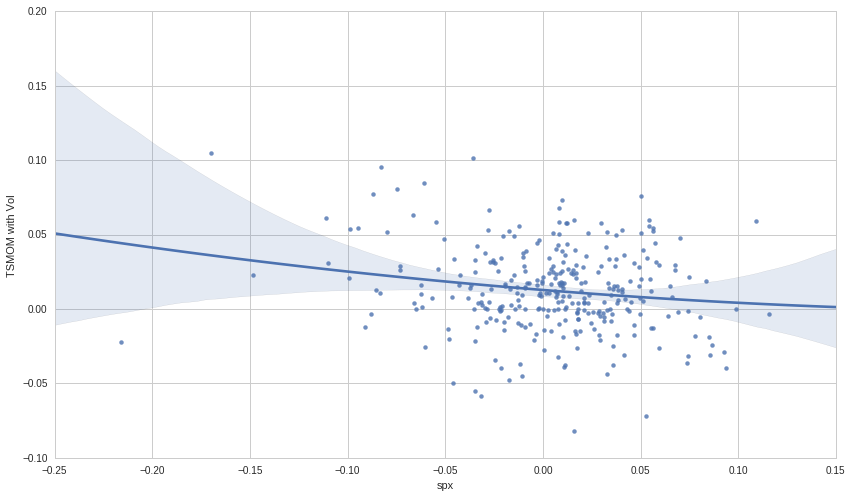

In [38]:
comb = TSMOM.merge(SPX)
sns.regplot(x="spx", y="TSMOM with Vol", data=comb, order=2);

In [39]:
X = comb['spx'].copy()
X = sm.add_constant(X)
model = sm.OLS(comb['TSMOM with Vol'].astype(float), X).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:         TSMOM with Vol   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     9.535
Date:                Tue, 22 Nov 2016   Prob (F-statistic):            0.00220
Time:                        10:51:01   Log-Likelihood:                 675.59
No. Observations:                 312   AIC:                            -1347.
Df Residuals:                     310   BIC:                            -1340.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0132      0.002      8.319      0.0

**Note** the positive alpha and significant coefficient relating to S&P 500.

In [40]:
X = comb['spx'].copy()
X = X ** 2
Y = comb['TSMOM with Vol']
Y = Y ** 2
model = sm.OLS(Y, X).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:         TSMOM with Vol   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     61.66
Date:                Tue, 22 Nov 2016   Prob (F-statistic):           6.67e-14
Time:                        10:51:02   Log-Likelihood:                 1553.1
No. Observations:                 312   AIC:                            -3104.
Df Residuals:                     311   BIC:                            -3101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
spx            0.1667      0.021      7.852      0.0

# Straddle like payoff

In MOP paper, they states the returns to TSMOM are largest during the biggest up and down market movements. In addition, the coefficient on the market return squared is significantly positive, indicating that TSMOM delivers its highest profits during the most extreme market movements. The result above also concur with their findings.

The take away from this is that TSMOM has payoffs similar to an option straddle on the market. 

# Conclusion

The benchmarks used for the factor analysis are:
* EQUITY - MSCI World equity index
* BOND - Barclay's Aggregate Bond Index
* COMMODITY - S&P GSCI Index
* SMB - Size
* HML - Value vs growth
* MOM - Cross sectional Momentum

The SMB, HML, MOM data are from Kenneth French's [data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). Rest of the data are from Bloomberg after adjusting for risk free rate.

The performance of TSMOM has been quite impressive with the Sharpe ratio at 1.56 for 1984-2009 and 1.32 if we cover the 1984-2016 period. Without volatility scaling, the Sharpe ratio drop down to 1.18. Compare this to buy and hold strategy with and without volatility scaling which generated Sharpe Ratio of 0.196 and -0.088 respectively. Against other metrics such as maximum draw down, the TSMOM with and without volatility scaling also outperformed.

When one take a look at the factor analyis, TSMOM with volatility scaling is negatively correlated to the MSCI World Index and uncorrelated to the rest of the factors. The alpha is 1.2% per month. However, one must take this with a grain of salt as the adjusted R-squared is only 0.02.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*